In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split, KFold
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import numpy as np
import time
import os
from PIL import Image

%matplotlib inline

In [2]:
# import glob

# data_path = '../../data/caffe_drinks/'
# class_names = os.listdir(data_path)

# for name in class_names:
#     image_list = glob.glob(data_path + name + '/*')
    
#     for image in image_list:
#         img = Image.open(image)
#         img_channel = len(img.split())
        
#         if img_channel != 3:
#             print(image)
    
#     print(name, 'Done')

In [3]:
EPOCH = 80
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 4
TEST_SIZE = 0.20
LEARNING_RATE = 0.001
MOMENTUM = 0.9
FOLD_N = 2
CLASS_NUM = 9

# GPU 여부
if torch.cuda.is_available(): device = torch.device('cuda') 
else: device = torch.device('cpu')
print('We are Using :', device)

torch.manual_seed(42)

We are Using : cuda


In [4]:
class WrapperDataset:
    def __init__(self, dataset, transform=None, target_transform=None):
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        image, label = self.dataset[index]
        
        if self.transform is not None:
            image = self.transform(image)
            
        if self.target_transform is not None:
            label = self.target_transform(label)
            
        return image, label

    def __len__(self):
        return len(self.dataset)

In [5]:
def train(model, loss_func, optimizer, device, dataloader):
    total_loss, accuracy = 0, 0
    total_samples, correct_samples = 0, 0
    
    model.train()
    
    for i, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        
        loss = loss_func(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        total_loss += loss.detach().cpu()
        
        preds = outputs.argmax(1)
        total_samples += preds.size()[0]
        correct_samples += preds.eq(labels.view_as(preds)).cpu().sum().item()
        
    accuracy = (correct_samples / total_samples) * 100
    
    return total_loss/total_samples, accuracy

def test(model, loss_func, device, dataloader):
    total_loss, accuracy = 0, 0
    total_samples, correct_samples = 0, 0
    
    model.eval()
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            loss = loss_func(outputs, labels)
            total_loss += loss.detach().cpu()

            preds = outputs.argmax(1)
            total_samples += preds.size()[0]
            correct_samples += preds.eq(labels.view_as(preds)).cpu().sum().item()

        accuracy = (correct_samples / total_samples) * 100  
    
    return total_loss/total_samples, accuracy


def draw_matrix(model, device, dataloader, class_num):
    total_samples, correct_samples = 0, 0
    
    model.eval()
    
    confusion_matrix = torch.zeros(CLASS_NUM, CLASS_NUM)
       
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            preds = outputs.argmax(1)
            total_samples += preds.size()[0]
            correct_samples += preds.eq(labels.view_as(preds)).cpu().sum().item()
                 
            # Make Confusion Matrix
            for row, col in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[row.long(), col.long()] += 1
    
    return confusion_matrix

In [6]:
data_path = '../../data/caffe_drinks/'
dataset = ImageFolder(root=data_path)

kfold = KFold(n_splits=FOLD_N, shuffle=True)

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset)):
    print('--------------------------------')
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    train_subsampler = SubsetRandomSampler(train_idx)
    test_subsampler = SubsetRandomSampler(test_idx)
    
    trainloader = DataLoader(WrapperDataset(dataset,transform=train_transform),
                            batch_size=TRAIN_BATCH_SIZE,
                            sampler=train_subsampler)                                                                                        
    testloader = DataLoader(WrapperDataset(dataset, transform=test_transform),
                            batch_size=TEST_BATCH_SIZE,
                            sampler=test_subsampler)
    
    model = torchvision.models.resnet152(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(2048, CLASS_NUM)
    model = model.to(device)
    
    #optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_func = nn.CrossEntropyLoss()
    
    train_loss_per_epoch = []
    train_acc_per_epoch = []
    test_loss_per_epoch = []
    test_acc_per_epoch = []


    for epoch in range(EPOCH):
        start_time = time.time()

        train_loss, train_acc = train(model, loss_func, optimizer, device, trainloader)
        test_loss, test_acc = test(model, loss_func, device, testloader)

        train_loss_per_epoch.append(train_loss)
        train_acc_per_epoch.append(train_acc)
        test_loss_per_epoch.append(test_loss)
        test_acc_per_epoch.append(test_acc)
        
        confusion_matrix = draw_matrix(model, device, testloader, CLASS_NUM)

        print('Epoch %d / %d ---- train_loss: %0.4f ---- train_acc: %0.4f ---- test_loss: %0.4f ---- test_acc: %0.4f'
             %(epoch+1, EPOCH, train_loss, train_acc, test_loss, test_acc))

--------------------------------
FOLD 0
--------------------------------
Epoch 1 / 80 ---- train_loss: 0.0396 ---- train_acc: 61.9334 ---- test_loss: 0.1790 ---- test_acc: 82.5162
Epoch 2 / 80 ---- train_loss: 0.0207 ---- train_acc: 81.1748 ---- test_loss: 0.1361 ---- test_acc: 84.6901
Epoch 3 / 80 ---- train_loss: 0.0169 ---- train_acc: 83.9038 ---- test_loss: 0.1220 ---- test_acc: 85.8002
Epoch 4 / 80 ---- train_loss: 0.0151 ---- train_acc: 84.8751 ---- test_loss: 0.1133 ---- test_acc: 86.3090
Epoch 5 / 80 ---- train_loss: 0.0137 ---- train_acc: 86.2165 ---- test_loss: 0.1215 ---- test_acc: 82.7937
Epoch 6 / 80 ---- train_loss: 0.0126 ---- train_acc: 87.0028 ---- test_loss: 0.1053 ---- test_acc: 86.4015
Epoch 7 / 80 ---- train_loss: 0.0116 ---- train_acc: 88.1591 ---- test_loss: 0.0944 ---- test_acc: 87.5578
Epoch 8 / 80 ---- train_loss: 0.0108 ---- train_acc: 88.9454 ---- test_loss: 0.0915 ---- test_acc: 88.0666
Epoch 9 / 80 ---- train_loss: 0.0106 ---- train_acc: 88.8992 ---- test_

Epoch 77 / 80 ---- train_loss: 0.0053 ---- train_acc: 93.5708 ---- test_loss: 0.0860 ---- test_acc: 89.0842
Epoch 78 / 80 ---- train_loss: 0.0055 ---- train_acc: 93.2932 ---- test_loss: 0.0828 ---- test_acc: 89.5005
Epoch 79 / 80 ---- train_loss: 0.0046 ---- train_acc: 95.0509 ---- test_loss: 0.0923 ---- test_acc: 88.7142
Epoch 80 / 80 ---- train_loss: 0.0054 ---- train_acc: 93.7558 ---- test_loss: 0.0872 ---- test_acc: 89.4542
--------------------------------
FOLD 1
--------------------------------
Epoch 1 / 80 ---- train_loss: 0.0412 ---- train_acc: 58.8807 ---- test_loss: 0.1970 ---- test_acc: 79.0009
Epoch 2 / 80 ---- train_loss: 0.0204 ---- train_acc: 83.0250 ---- test_loss: 0.1312 ---- test_acc: 85.8002
Epoch 3 / 80 ---- train_loss: 0.0172 ---- train_acc: 84.0888 ---- test_loss: 0.1138 ---- test_acc: 86.5402
Epoch 4 / 80 ---- train_loss: 0.0148 ---- train_acc: 85.9389 ---- test_loss: 0.1051 ---- test_acc: 87.1415
Epoch 5 / 80 ---- train_loss: 0.0133 ---- train_acc: 87.4653 ---- t

Epoch 73 / 80 ---- train_loss: 0.0059 ---- train_acc: 93.5245 ---- test_loss: 0.0950 ---- test_acc: 87.9278
Epoch 74 / 80 ---- train_loss: 0.0057 ---- train_acc: 92.9695 ---- test_loss: 0.0903 ---- test_acc: 88.1129
Epoch 75 / 80 ---- train_loss: 0.0049 ---- train_acc: 94.4496 ---- test_loss: 0.0985 ---- test_acc: 87.3265
Epoch 76 / 80 ---- train_loss: 0.0054 ---- train_acc: 93.7558 ---- test_loss: 0.0906 ---- test_acc: 88.4366
Epoch 77 / 80 ---- train_loss: 0.0045 ---- train_acc: 95.0509 ---- test_loss: 0.0934 ---- test_acc: 87.8816
Epoch 78 / 80 ---- train_loss: 0.0051 ---- train_acc: 94.3571 ---- test_loss: 0.0943 ---- test_acc: 87.5116
Epoch 79 / 80 ---- train_loss: 0.0053 ---- train_acc: 93.7095 ---- test_loss: 0.0952 ---- test_acc: 87.5578
Epoch 80 / 80 ---- train_loss: 0.0051 ---- train_acc: 94.4496 ---- test_loss: 0.0893 ---- test_acc: 87.7891


In [8]:
label_to_name = {v:k for k,v in dataset.class_to_idx.items()}
print('Label to Name : ', label_to_name)

confusion_matrix = draw_matrix(model, device, testloader, CLASS_NUM)
result = confusion_matrix.diag()/confusion_matrix.sum(1)

print('--------Accuracy of Each Class--------')
for name, acc in zip(label_to_name.values(), result):
    print('%s : %0.2f%%' %(name, acc * 100))

Label to Name :  {0: 'americano', 1: 'bubbletea_blacksugar', 2: 'cappuccino', 3: 'caramel_macchiato', 4: 'frappuccino_javachip', 5: 'latte_Strawberry', 6: 'latte_goguma', 7: 'latte_greentea', 8: 'mango_juice'}
--------Accuracy of Each Class--------
americano : 94.88%
bubbletea_blacksugar : 86.63%
cappuccino : 81.75%
caramel_macchiato : 88.24%
frappuccino_javachip : 89.53%
latte_Strawberry : 94.83%
latte_goguma : 70.97%
latte_greentea : 88.02%
mango_juice : 96.12%


    train_loss_per_epoch = []
    train_acc_per_epoch = []
    test_loss_per_epoch = []
    test_acc_per_epoch = []

ValueError: x and y must have same first dimension, but have shapes (80,) and (2,)

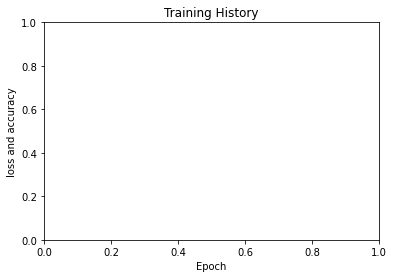

In [9]:
import matplotlib.pyplot as plt

x = range(1,81)
y = [train_loss_per_epoch, test_loss_per_epoch]
plt.xlabel("Epoch")
plt.ylabel("loss and accuracy")
plt.title("Training History")
for i in range(len(y[0])):
    plt.plot(x,[pt[i] for pt in y],label = 'id %s'%i)
plt.legend()
plt.show()